# Low Resource Language ASR model
### Lars Ericson, Catskills Research Company, OpenASR20

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np

## Language Analysis

In [14]:
from Language import Language
L=Language('amharic')

100%|██████████| 9842/9842 [00:01<00:00, 7891.53it/s]


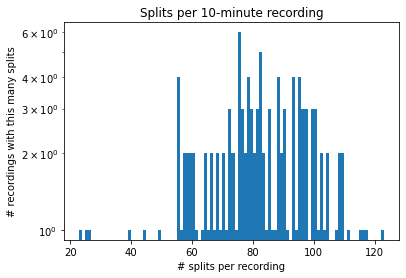

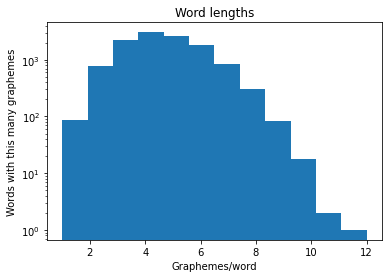

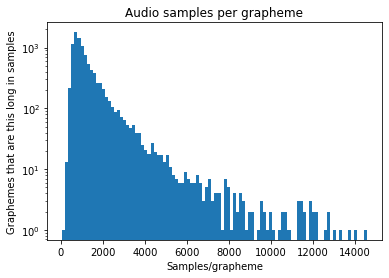

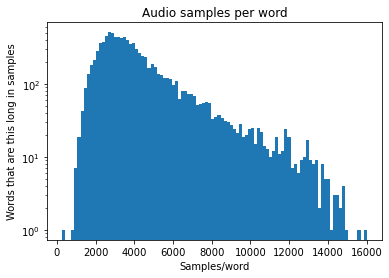

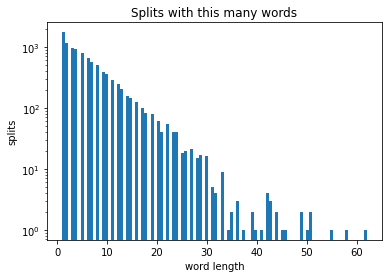

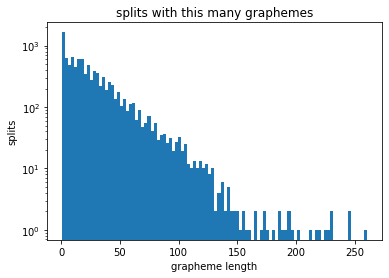

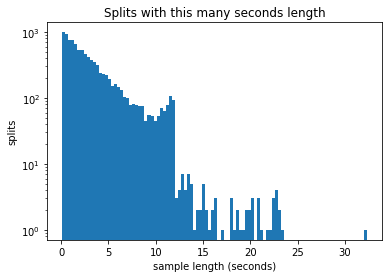

In [15]:
L.visualization()

In [22]:
L.sample_statistics()

,Corpus,Units,Measurement,Value
0,Recordings,#Hours,Hours of training speech,20.333333
1,Recordings,#Recordings,10-minute training recordings,122.000000
0,Graphemes,#Graphemes,Distinct graphemes in all transcriptions,234.000000
1,Graphemes,Length in samples,Max,14560.000000
2,Graphemes,Length in samples,Mean,1350.801423
3,Graphemes,Length in samples,Median,971.637255
4,Graphemes,Length in samples,Min,67.692308
5,Graphemes,Length in seconds,Max,1.820000
6,Graphemes,Length in seconds,Mean,0.168850
7,Graphemes,Length in seconds,Median,0.121455


## Sub splitting based on words per split and average samples per grapheme (imperfect, introduces error)

### Start by visualizing and skipping single-word samples but also doing the language analysis on the set

## Language analysis after sub-splitting

## ASR end-to-end speech-to-grapheme model stacked on top of grapheme-to-grapheme corrector model

In [ ]:
C.extension='_gradscaler'
C.batch_size=12
C.save_every = 5
C.start_from = 246

In [ ]:

import json, sys, os, librosa, random, math, time, torch
sys.path.append('/home/catskills/Desktop/openasr20/end2end_asr_pytorch')
os.environ['IN_JUPYTER']='True'
import numpy as np
import pandas as pd

from itertools import groupby
from operator import itemgetter
import soundfile as sf
from utils import constant
from utils.functions import load_model
from utils.data_loader import SpectrogramDataset, AudioDataLoader, BucketingSampler
from clip_ends import clip_ends
import torch.optim as optim
import torchtext
from torchtext.data import Field, BucketIterator
from torchtext.data import TabularDataset
import matplotlib.ticker as ticker
from IPython.display import Audio
from unidecode import unidecode
from seq_to_seq import *

In [ ]:
files=glob(f'{C.nr_dir}/*')
n_samples=len(files)
samples=list(sorted([(librosa.load(audio_file, sr=C.sample_rate)[0].shape[0], audio_file) for audio_file in files]))

In [ ]:
samples[0]

In [ ]:
long_samples=samples[4842:]

In [ ]:
long_sample=long_samples[0][1]
long_sample

In [ ]:
tgt_fn=f"{long_sample[0:-4].replace('/audio_split_8000','/transcription_split')}.txt"
tgt_fn

In [ ]:
gold_tgt=open(tgt_fn).read()
gold_tgt

In [ ]:
sound=librosa.load(long_sample, sr=C.sample_rate)[0]

In [ ]:
def split_on_longest_silence(sound, sample_rate, _cutoff = 0.0014, debug=None):
    N=100
    min_gap=0.04*sample_rate
    audio_moving=np.convolve(sound**2, np.ones((N,))/N, mode='same') 
    if debug:
        print(f'average energy over {N} sample window')
        plt.figure(figsize=(40,4))
        plt.plot(sound)
        plt.plot(audio_moving);
        plt.title(unidecode(debug))
        plt.show()
    if 0:
        threshold=0.3
        amplitudes=np.sort(audio_moving)
        n_amp=audio_moving.shape[0]
        cutoff=amplitudes[int(n_amp*threshold)]
    else:
        cutoff = _cutoff
    if debug:
        print('cutoff', cutoff)
    silence_mask=audio_moving < cutoff
    groups = [[i for i, _ in group] for key, group in groupby(enumerate(silence_mask), key=itemgetter(1)) if key]
    boundaries=[(x[0],x[-1]) for x in groups]
    silences=[(x,(y-N)) for x,y in boundaries if y-x > min_gap]
    if not silences:
        print('no silence')
        display(Audio(sound, rate=C.sample_rate))
        return (sound, None)
    if debug:
        print('#silences', len(silences))
        plt.figure(figsize=(50,8))
        plt.plot(sound);
        plt.xlabel('seconds')
        plt.ylabel('amplitude');
        for (x1,x2) in silences:
            plt.plot([x1,x2],[0,0],linewidth=5,color='red')
        plt.title('sound and detected silence')
        plt.show()
    longest_silence=list(sorted([(y-x, (x,y)) for x,y in silences]))[-1][1]
    midpoint_of_longest_silence=longest_silence[0]+((longest_silence[1]-longest_silence[0])//2)
    speech=[(0,midpoint_of_longest_silence), (midpoint_of_longest_silence,sound.shape[0])]
    sounds=[clip_ends(sound[a:b], 0.0008) for a,b in speech]
    if debug:
        spliced=np.hstack(sounds)
        plt.figure(figsize=(50,8))
        plt.plot(spliced);
        plt.xlabel('seconds')
        plt.ylabel('amplitude');
        plt.title('spliced')
        print(f'sound: {unidecode(debug)}')
        display(Audio(sound, rate=C.sample_rate))
        print('spliced')
        display(Audio(spliced, rate=C.sample_rate))
        for i, sound in enumerate(sounds):
            print('segment', i)
            display(Audio(sound, rate=C.sample_rate))
            plt.figure(figsize=(50,8))
            plt.plot(sound);
            plt.xlabel('seconds')
            plt.ylabel('amplitude');
            plt.title(f"segment {i}")
        plt.show()
    return sounds

In [ ]:
s1,s2=split_on_longest_silence(sound, C.sample_rate, 0.001, gold_tgt)

In [ ]:
s1a,s1b=split_on_longest_silence(s1, C.sample_rate, 0.001, gold_tgt)

In [ ]:
s2a,s2b=split_on_longest_silence(s2, C.sample_rate, 0.001, gold_tgt)

In [ ]:
s2b1,s2b2=split_on_longest_silence(s2b, C.sample_rate,  0.001, gold_tgt)

In [ ]:
s2b1a,s2b1b=split_on_longest_silence(s2b1, C.sample_rate,  0.001, gold_tgt)

In [ ]:
s2b2a,s2b2b=split_on_longest_silence(s2b2, C.sample_rate,  0.001, gold_tgt)

In [ ]:
unidecode(gold_tgt)

In [ ]:
!mkdir -p frob
!rm frob/*

In [ ]:
clips=[]
for i, sound in enumerate(sounds):
    fn=f"frob/clip_{i}.wav"
    sf.write(fn, sound, C.sample_rate)
    clips.append(fn)

In [ ]:
text='infer.txt'
manifest_fn='manifest.csv'
manifest='\n'.join([f'{audio},{text}' for audio in clips])
with open(manifest_fn, 'w') as f:        plt.show()
    f.write(manifest)

In [ ]:
!cat manifest.csv

In [ ]:
args=constant.args
args.continue_from=None
args.cuda = True
args.labels_path = C.grapheme_dictionary_fn
args.lr = 1e-4
args.name = C.model_name
args.save_folder = f'save'
args.epochs = 1000
args.save_every = 1
args.feat_extractor = f'vgg_cnn'
args.dropout = 0.1
args.num_layers = 4
args.num_heads = 8
args.dim_model = 512
args.dim_key = 64
args.dim_value = 64
args.dim_input = 161
args.dim_inner = 2048
args.dim_emb = 512
args.shuffle=True
args.min_lr = 1e-6
args.k_lr = 1
args.sample_rate=C.sample_rate
args.continue_from=C.best_model
args.augment=True
audio_conf = dict(sample_rate=args.sample_rate,
                  window_size=args.window_size,
                  window_stride=args.window_stride,
                  window=args.window,
                  noise_dir=args.noise_dir,
                  noise_prob=args.noise_prob,
                  noise_levels=(args.noise_min, args.noise_max))

In [ ]:
with open(args.labels_path, 'r') as label_file:
    labels = str(''.join(json.load(label_file)))
# add PAD_CHAR, SOS_CHAR, EOS_CHAR
labels = constant.PAD_CHAR + constant.SOS_CHAR + constant.EOS_CHAR + labels
label2id, id2label = {}, {}
count = 0
for i in range(len(labels)):
    if labels[i] not in label2id:
        label2id[labels[i]] = count
        id2label[count] = labels[i]
        count += 1
    else:
        print("multiple label: ", labels[i])

model, opt, epoch, metrics, loaded_args, label2id, id2label = load_model(constant.args.continue_from)

In [ ]:
train_data = SpectrogramDataset(audio_conf, manifest_filepath_list=[manifest_fn], 
                                label2id=label2id, normalize=True, augment=args.augment)
args.batch_size=1
train_sampler = BucketingSampler(train_data, batch_size=args.batch_size)
train_loader = AudioDataLoader(train_data, num_workers=args.num_workers, batch_sampler=train_sampler)

strs_hyps=[]
for i, (data) in enumerate(tqdm(train_loader)):
    src, tgt, _, src_lengths, tgt_lengths = data
    src = src.cuda()
    tgt = tgt.cuda()
    pred, gold, hyp_seq, gold_seq = model(src, src_lengths, tgt, verbose=False)
    seq_length = pred.size(1)
    for ut_hyp in hyp_seq:
        str_hyp = ""
        for x in ut_hyp:
            if int(x) == constant.PAD_TOKEN:
                break
            str_hyp = str_hyp + id2label[int(x)]
        strs_hyps.append(str_hyp)
for j in range(len(strs_hyps)):
    strs_hyps[j] = strs_hyps[j].replace(constant.SOS_CHAR, '').replace(constant.EOS_CHAR, '')

In [ ]:
gold_tgt = ' '.join([x.strip() for x in gold_tgt.split(' ') if x])
gold_tgt

In [ ]:
pred=' '.join(strs_hyps)
pred

In [ ]:
error_correction_training_fn='frob/pred_gold.tsv'
with open(error_correction_training_fn, 'w', encoding='utf-8') as f:
    f.write(f"{gold_tgt}\t{pred}")

In [ ]:
!cat frob/pred_gold.tsv

In [ ]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
tokenize=lambda x: [y for y in x]

SRC = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [ ]:
from torchtext.data import Iterator

In [ ]:
train_data = TabularDataset(
    path=error_correction_training_fn,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)])

In [ ]:
train_iterator = Iterator(train_data, batch_size=1)

In [ ]:
gold_fns=list(sorted(glob(f'{C.build_dir}/transcription_split/*.txt')))
len(gold_fns)
import os
goldrows=[]
for fn in gold_fns:
    with open(fn, 'r', encoding='utf-8') as f:
        goldrows.append(f.read())

MAX_LENGTH=max(len(x) for x in goldrows)+10
MAX_LENGTH

graphemes=''.join([x for x in C.grapheme_dictionary])

MIN_FREQ=1

In [ ]:
SRC.build_vocab(graphemes, min_freq = MIN_FREQ)

In [ ]:
TRG.build_vocab(graphemes, min_freq = MIN_FREQ)
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
INPUT_DIM, OUTPUT_DIM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [ ]:
enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device,
              MAX_LENGTH)

In [ ]:
dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              MAX_LENGTH)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

In [ ]:
model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
model_fn='tut6-model.pt'

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

if os.path.exists(model_fn):
    model.load_state_dict(torch.load(model_fn))

LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
model.train()

In [ ]:
for j in range(100):
    epoch_loss = 0
    for i, batch in enumerate(train_iterator):

        src = batch.src.to(device)
        trg = batch.trg.to(device)

        optimizer.zero_grad()

        output, _ = model(src, trg[:,:-1])
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()

        epoch_loss += loss.item()
        
    print(j, epoch_loss)

In [ ]:
pred=output.argmax(1).cpu().detach().numpy()
pred

In [ ]:
''.join([SRC.vocab.itos[x] for x in src.cpu().numpy()[0]])

In [ ]:
silver=''.join([TRG.vocab.itos[x] for x in trg.cpu().numpy()]).split('<eos>')[0]
silver

In [ ]:
pred=''.join([TRG.vocab.itos[x] for x in pred]).split('<eos>')[0]
pred

In [ ]:
from utils.metrics import calculate_cer, calculate_wer

In [ ]:
calculate_cer(pred, silver)

In [ ]:
calculate_wer(pred, silver)